[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


  1%|▏         | 67/5000 [00:00<00:07, 656.93it/s]C:\Users\clint\AppData\Local\Temp\ipykernel_9228\1093777548.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pfs_returns[i] = _pf_returns
C:\Users\clint\AppData\Local\Temp\ipykernel_9228\1093777548.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pfs_returns[i] = _pf_returns
C:\Users\clint\AppData\Local\Temp\ipykernel_9228\1093777548.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

<AxesSubplot: title={'center': 'Sample of Random Portfolios'}>

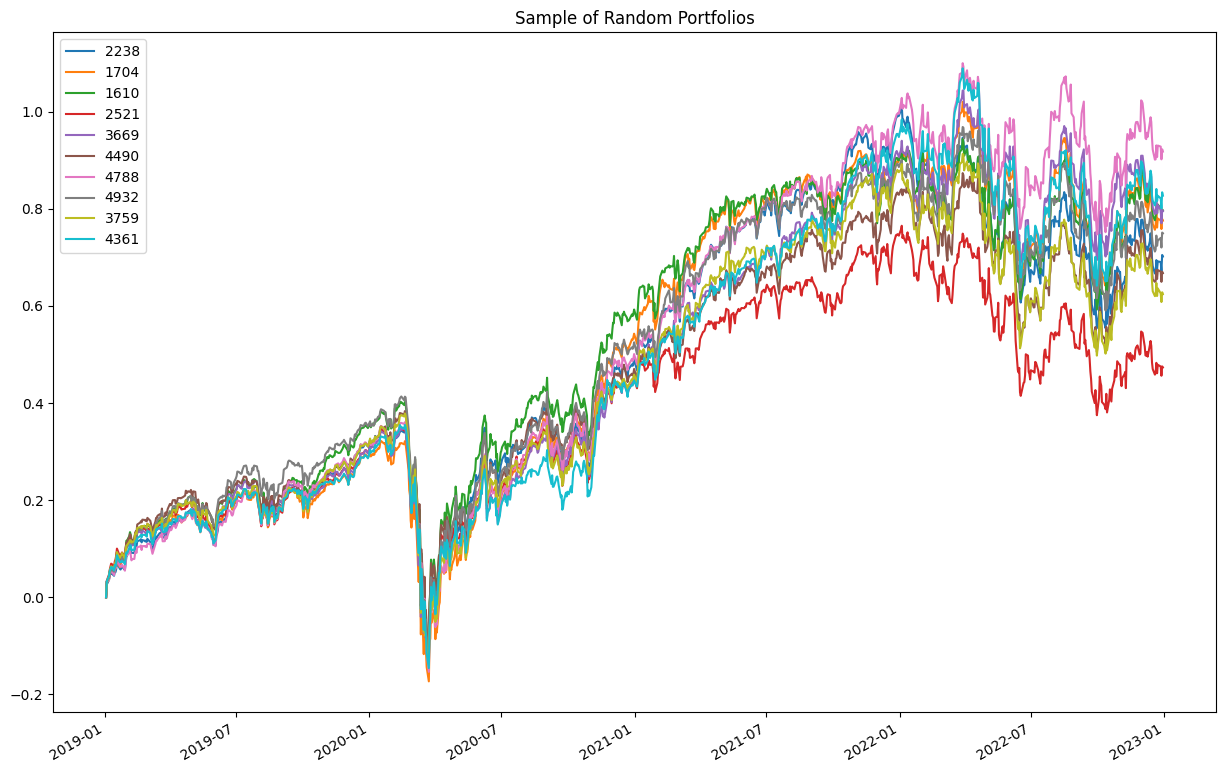

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import skewnorm, norm

from src.utils import skew_to_alpha, moments
from src.sharpe_ratio_stats import estimated_sharpe_ratio, ann_estimated_sharpe_ratio, probabilistic_sharpe_ratio, num_independent_trials, expected_maximum_sr, deflated_sharpe_ratio
#np.random.seed(0)
import yfinance as yf
import pandas as pd

# Define the ETF symbols and sector names
etf_symbols = ['XLC', 'XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLK', 'XLU']
sector_names = ['Communication Services', 'Consumer Discretionary', 'Consumer Staples', 'Energy', 'Financials', 'Health Care', 'Industrials', 'Technology', 'Utilities']

# Define the start and end dates
start_date = '2019-01-01'
end_date = '2023-01-01'

# Download the data
etf_sector_returns = pd.DataFrame()
for symbol, sector in zip(etf_symbols, sector_names):
    data = yf.download(symbol, start=start_date, end=end_date)['Adj Close'].pct_change().dropna()
    data.name = sector
    etf_sector_returns = pd.concat([etf_sector_returns, data], axis=1)
etf_sector_returns.head()

from sklearn.preprocessing import normalize

etf_sector_returns_normalized = normalize(etf_sector_returns, axis=0)
etf_sector_returns_normalized = pd.DataFrame(etf_sector_returns_normalized, columns=etf_sector_returns.columns, index=etf_sector_returns.index)
etf_sector_returns
# Load universe

etfs_returns = etf_sector_returns
universe = etf_sector_returns.columns



# Define methods
def generate_random_weights():
    l = [0.01, 0.25, 0.5, 0.75, 1]  # do not use 0, for avoiding zero division
    
    random_weights = np.random.choice(l, size=(etfs_returns.shape), replace=True)
    random_weights = np.divide(random_weights, random_weights.sum(axis=1)[:, None])
        
    weights_df = pd.DataFrame(random_weights, index=etfs_returns.index, columns=etfs_returns.columns)
    
    return weights_df
def simulate(assets_returns, assets_weights):
    assets_weights = assets_weights.ffill()
    pf_returns = assets_returns.add(1).mul(assets_weights.shift(1)).sum(axis=1).sub(1)
    pf_returns.iloc[0] = 0  # first day return is 0, because we do not have weights for yesterday
    return pf_returns

def returns_to_equity(returns):
    equity = returns.add(1).cumprod().sub(1)
    return equity
# Run simulations
M = 5000

df_pfs_returns = pd.DataFrame()

for i in tqdm(range(M)):
    random_weights = generate_random_weights()
    
    _pf_returns = simulate(etfs_returns, random_weights)
    
    df_pfs_returns[i] = _pf_returns
#Plot 10 random portfolios 
returns_to_equity(df_pfs_returns.sample(n=10, axis=1)).plot(figsize=(15, 10), legend=True, title='Sample of Random Portfolios')


<AxesSubplot: >

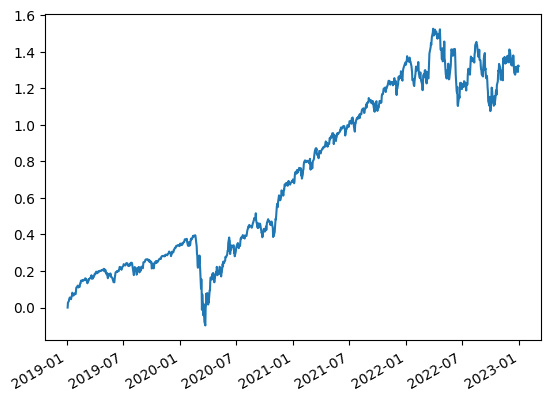

In [2]:
#We now have random portfolio alocations for industry sector ETFs
# We look for highest SR and PSR
ann_best_srs = ann_estimated_sharpe_ratio(df_pfs_returns).sort_values(ascending=False)
prob_best_srs=probabilistic_sharpe_ratio(returns=df_pfs_returns, sr_benchmark=0).sort_values(ascending=False)
ann_best_srs

best_psr_pf_name = probabilistic_sharpe_ratio(returns=df_pfs_returns, sr_benchmark=0).sort_values(ascending=False).index[0]
best_psr_pf_returns = df_pfs_returns[best_psr_pf_name]
best_psr_pf_name
returns_to_equity(best_psr_pf_returns).plot() #plot equity curve line

In [3]:
dsr = deflated_sharpe_ratio(trials_returns=df_pfs_returns, returns_selected=best_psr_pf_returns)
print("The best portfolio is portfolio",ann_best_srs.index[0],"with Sharpe Ratio",ann_best_srs.iloc[0],"and Prob. Sharpe Ratio",prob_best_srs[0],"the deflated sharpe ratio is",dsr)


The best portfolio is portfolio 3349 with Sharpe Ratio 1.0720169127655013 and Prob. Sharpe Ratio 0.914044263408687 the deflated sharpe ratio is 0.9449609459110465
